In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Load the data #

In [2]:
# Reading csv dataset and shuffle it
data = pd.read_csv("./raw_data/atp_matches_till_2022.csv").sample(frac=1.0).reset_index(drop=True)

# New player info df
player = pd.read_csv("./raw_data/atp_players_till_2022.csv")

# Clean the data #

In [3]:
# Removing undesired championship and bad scores
data = data.drop(data[data['tourney_id'] == '1968-9295'].index)
data = data[~data['score'].str.contains('[A-Za-z]', na=False)]
data = data[~data['round'].str.contains('BR', na=False)]
data = data[~data['round'].str.contains('ER', na=False)]
data = data[~data['round'].str.contains('RR', na=False)]
data = data[data['l_bpSaved'] >= 0]

# Changing all unknown hands for U and other things
player.loc[26080, 'hand'] = 'U'

In [4]:
# Changing U hand players with random R and L
player.loc[player[player['hand'] == 'U']['hand'].index, 'hand'] = random.choices(population=[['R'], ['L']],weights=[0.91, 0.09], k=41563)

In [5]:
# Concatenate player_id, name_first, and name_last into a new column 'player'
player['player'] = player['player_id'].astype(str) + ' - ' + player['name_first'] + ' ' + player['name_last']

# Drop the columns 'dob', 'ioc', and 'wikidata_id', plus all player info
cols_to_drop = ['dob', 'ioc', 'wikidata_id', 'player_id', 'name_first', 'name_last']
player.drop(columns=cols_to_drop, inplace=True)

# Fill the NaN values in the 'height' column with the mean height and mode for hand
player['height'] = round(player['height'].fillna(player['height'].mean()), 2)
player['hand'] = player['hand'].fillna(player['hand'].mode()[0])

In [6]:
# Creating height and age difference columns
data['ht_diff'] = (data['winner_ht'] - data['loser_ht']).abs()
data['age_diff'] = (data['winner_age'] - data['loser_age']).abs()

In [7]:
# Putting together the player ID with it's name
data['winner_id'] = data['winner_id'].astype(str)
data['winner_name'] = data['winner_name'].astype(str)
data['winner'] = data['winner_id'] + ' - ' + data['winner_name']

data['loser_id'] = data['loser_id'].astype(str)
data['loser_name'] = data['loser_name'].astype(str)
data['loser'] = data['loser_id'] + ' - ' + data['loser_name']

In [8]:
# Dropping player ID and name
data.drop(columns=['winner_id', 'winner_name', 'loser_id', 'loser_name'], inplace=True)

In [9]:
# Dropping unused columns
cols_to_drop = [
    'winner_seed',
    'winner_entry',
    'loser_seed',
    'loser_entry',
    'tourney_id',
    'tourney_name',
    'match_num',
    'tourney_level',
    'tourney_date',
    'score',
    'winner_rank_points',
    'loser_rank_points',
    'winner_ioc',
    'loser_ioc',
    'w_svpt',
    'w_1stIn',
    'w_1stWon',
    'w_2ndWon',
    'w_SvGms',
    'l_svpt',
    'l_1stIn',
    'l_1stWon',
    'l_2ndWon',
    'l_SvGms',
    'winner_rank',
    'loser_rank'
    ]
new_data = data.drop(columns=cols_to_drop)

In [10]:
# Filling hand and height with the mode and mean
new_data[['winner_hand', 'loser_hand']] = new_data[['winner_hand', 'loser_hand']].fillna('R', axis=1)
new_data[['winner_ht', 'loser_ht']] = new_data[['winner_ht', 'loser_ht']].fillna(183.74, axis=1)

In [11]:
# Dropping rows that have empty values
new_data = new_data.dropna()

In [12]:
# Rounding values of height and age
new_data[['winner_ht', 'loser_ht']] = round(new_data[['winner_ht', 'loser_ht']], 2)
new_data[['winner_age', 'loser_age']] = round(new_data[['winner_age', 'loser_age']])

In [13]:
# Create a copy for winners and losers
winner_df = new_data.copy()
loser_df = new_data.copy()

In [14]:
# Filling target column with 1 (win) and 0 (lose)
winner_df['target'] = 1
loser_df['target'] = 0

In [15]:
# Rename 'winner' and 'loser' in winner_df
winner_df.rename(columns={col: col.replace('winner', 'player_1') for col in winner_df.columns if 'winner' in col}, inplace=True)
winner_df.rename(columns={col: col.replace('loser', 'player_2') for col in winner_df.columns if 'loser' in col}, inplace=True)

# Rename 'w_' and 'l_' in winner_df
winner_df.rename(columns={col: col.replace('w_', 'player_1_') for col in winner_df.columns if 'w_' in col}, inplace=True)
winner_df.rename(columns={col: col.replace('l_', 'player_2_') for col in winner_df.columns if 'l_' in col}, inplace=True)

# Rename draw_sizer
winner_df.rename(columns={'draplayer_1_size': 'draw_size'}, inplace=True)

# Rename 'loser' and 'winner' in loser_df
loser_df.rename(columns={col: col.replace('loser', 'player_1') for col in loser_df.columns if 'loser' in col}, inplace=True)
loser_df.rename(columns={col: col.replace('winner', 'player_2') for col in loser_df.columns if 'winner' in col}, inplace=True)

# Rename 'l_' and 'w_' in loser_df
loser_df.rename(columns={col: col.replace('l_', 'player_1_') for col in loser_df.columns if 'l_' in col}, inplace=True)
loser_df.rename(columns={col: col.replace('w_', 'player_2_') for col in loser_df.columns if 'w_' in col}, inplace=True)

# Rename draw_sizer
loser_df.rename(columns={'draplayer_2_size': 'draw_size'}, inplace=True)

In [16]:
# Concatenating both df's
df = pd.concat([winner_df, loser_df]).sort_index(kind='merge').reset_index(drop=True)

In [17]:
# Step 1: Extract unique players from player_1 and player_2 columns in df
unique_players_df = pd.concat([df['player_1'], df['player_2']]).unique()

In [18]:
# Step 2: Filter player_df to keep only the rows where 'player' is in unique_players_df
player = player[player['player'].isin(unique_players_df)]

In [19]:
# Duplicate rows adding the age range for each of them
age_ranges = ['- 20', '21 ~ 25', '26 ~ 30', '31 ~ 35', '36 ~ 40', '41 +']

player_df = pd.DataFrame(
    np.repeat(player.values, len(age_ranges), axis=0),
    columns=player.columns
)

player_df['age'] = np.tile(age_ranges, len(player))

In [20]:
# Adding new columns to player_df
new_columns = ['ace', 'df', 'bpSaved']
for col in new_columns:
    player_df.loc[:, col] = np.nan

In [21]:
# Creating new breakpoint column and drop unused columns
df['player_1_bpSaved'] = round(df['player_1_bpSaved'] / df['player_1_bpFaced'], 2)
df['player_2_bpSaved'] = round(df['player_2_bpSaved'] / df['player_2_bpFaced'], 2)
df[['player_1_bpSaved', 'player_2_bpSaved']] = df[['player_1_bpSaved', 'player_2_bpSaved']].fillna(0, axis=1)
df.drop(columns=['player_1_bpFaced', 'player_2_bpFaced'], inplace=True)

In [22]:
# Get the min max age from the age range
def parse_age_range(age_range):
    if age_range == '- 20':
        return 0, 20
    elif age_range == '41 +':
        return 41, float('inf')
    else:
        return map(int, age_range.split('~'))

In [23]:
# Filtering the player and age on the df
def filter_data(df, player_name, age_range):
    age_min, age_max = parse_age_range(age_range)

    # Filter for player_1
    player_1_mask = (df['player_1'] == player_name)
    age_1_mask = (df['player_1_age'] >= age_min) & (df['player_1_age'] <= age_max)
    filtered_player_1_df = df[player_1_mask & age_1_mask]

    # Filter for player_2
    player_2_mask = (df['player_2'] == player_name)
    age_2_mask = (df['player_2_age'] >= age_min) & (df['player_2_age'] <= age_max)
    filtered_player_2_df = df[player_2_mask & age_2_mask]

    return filtered_player_1_df, filtered_player_2_df

In [24]:
# Calculate the mean of the filtered data
def compute_means(filtered_df, new_columns, prefix):
    prefixed_columns = [prefix + col for col in new_columns]
    means = filtered_df[prefixed_columns].mean()
    means.index = new_columns
    return means

In [25]:
# Call the functions using every single player
for index, row in player_df.iterrows():
    player_name = row['player']
    age_range = row['age']

    filtered_player_1_df, filtered_player_2_df = filter_data(df, player_name, age_range)

    if not filtered_player_1_df.empty:
        means_player_1 = compute_means(filtered_player_1_df, new_columns, 'player_1_')
    else:
        means_player_1 = pd.Series([float('nan')] * len(new_columns), index=new_columns)

    if not filtered_player_2_df.empty:
        means_player_2 = compute_means(filtered_player_2_df, new_columns, 'player_2_')
    else:
        means_player_2 = pd.Series([float('nan')] * len(new_columns), index=new_columns)

    combined_means = means_player_1.add(means_player_2, fill_value=0) / 2

    player_df.loc[index, new_columns] = combined_means

In [26]:
# Drop rows where 'ace' or 'df' columns have NaN values
player_df.dropna(subset=['ace', 'df'], inplace=True)

# Creating the model #

In [27]:
# Creating a copy of main dataset
new_df = df.copy()

In [28]:
# Selecting the players + dropping the columns
cols_to_remove = ['player_1', 'player_2']
cols_removed = new_df[cols_to_remove]

new_df.drop(columns=cols_removed, inplace= True)

In [29]:
# Numerical and Categorical columns
num_cols = [
      'draw_size', 'player_1_ht', 'player_1_age',
       'player_2_ht', 'player_2_age', 'best_of',
       'minutes', 'player_1_ace', 'player_1_df', 'player_1_bpSaved',
       'player_2_ace', 'player_2_df', 'player_2_bpSaved', 'ht_diff',
       'age_diff'
]

cat_cols = [
    'surface', 'player_1_hand', 'player_2_hand', 'round'
]

## Pipelines ##

In [47]:
# Transform numerical and categorical variables
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

#Final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=5, max_features="sqrt", max_samples=0.8))
])

## Defining the model ##

In [48]:
# Features and target
X = new_df.drop(columns='target', axis=1)
y = new_df['target']

#Splitting in train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

cross_val_score(pipeline, X, y, cv=5, scoring='accuracy').mean()

model = pipeline.fit(X_train, y_train)

In [49]:
# Evaluate the model on the training set
train_predictions = model.predict(X_train)
train_score = accuracy_score(y_train, train_predictions)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_score = accuracy_score(y_test, test_predictions)

print(f'Training Accuracy: {train_score}')
print(f'Test Accuracy: {test_score}')
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


Training Accuracy: 0.8127621279269183
Test Accuracy: 0.7957805071315373


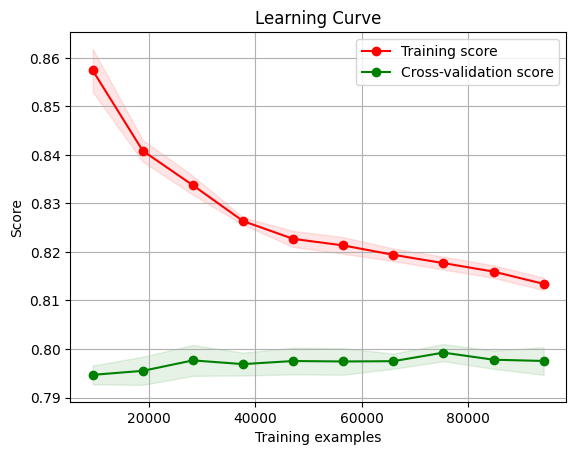

In [50]:
## Plotting the learning curves
plt.figure()

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')

plt.grid(True)
plt.show()

### Compress the data ###

In [51]:
# Reduces the size of the DataFrame by downcasting numerical columns
def compress(df, **kwargs):

    input_size = df.memory_usage(index=True).sum()/ 1024**2
    print("old dataframe size: ", round(input_size,2), 'MB')

    in_size = df.memory_usage(index=True).sum()

    for t in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=t))

        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=t)

    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100

    print("optimized size by {} %".format(round(ratio,2)))
    print("new DataFrame size: ", round(out_size / 1024**2,2), " MB")

    return df


In [52]:
new_df = compress(new_df, verbose=True)
new_df.head(1)

old dataframe size:  14.12 MB
optimized size by 0.0 %
new DataFrame size:  14.12  MB


,surface,draw_size,player_1_hand,player_1_ht,player_1_age,player_2_hand,player_2_ht,player_2_age,best_of,round,minutes,player_1_ace,player_1_df,player_1_bpSaved,player_2_ace,player_2_df,player_2_bpSaved,ht_diff,age_diff,target
0,Grass,32,R,183.0,24.0,L,183.0,23.0,3,R16,95.0,4.0,10.0,0.5,5.0,5.0,0.62,0.0,1.0,1


In [53]:
# Concatenating players back to the dataframe
final_df = pd.concat([new_df, cols_removed], axis= 1)

In [67]:
# Teste
# player_1 = "103819 - Roger Federer"
# player_2 = "104745 - Rafael Nadal"

# combined_row = pd.DataFrame([{
#     'player_1_df': 2.090909,
#     'player_2_df': 1.446194,
#     'player_1_ht': 185,
#     'player_2_ht': 185,
#     'surface': 'Clay',
#     'player_1_hand': 'R',
#     'player_2_hand': 'L',
#     'round': 'F',
#     'minutes': 160,
#     'player_1_ace': 7.189840,
#     'player_2_ace': 3.230971,
#     'player_1_age': 24,
#     'player_2_age': 24,
#     'draw_size': 32,
#     'best_of': 5,
#     'player_1_bpSaved': 0.571578,
#     'player_2_bpSaved': 0.539659,
#     'age_diff': 0,
#     'ht_diff': 0,
# }])

# predicted_outcome = pipeline.predict(combined_row)
# predicted_probabilities = pipeline.predict_proba(combined_row)

# if predicted_outcome[0] == 1:
#     print(f"{player_1} ganhou! com {round(predicted_probabilities[0][1] * 100, 2)}%")
# else:
#     print(f"{player_2} ganhou! com {predicted_probabilities[0][1]}")